## Bacterial chemotaxis
[Biomechanical ordering of dense cell populations](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)

### Imports

In [1]:
# Adding packages
using Pkg
Pkg.add("CellBasedModels")
Pkg.add("GLMakie")
Pkg.add("GeometryBasics")
Pkg.add("Distributions")

# Enabling packages
using CellBasedModels
using GLMakie
using GeometryBasics
using Distributions

Makie.inline!(true)

    Updating registry at `C:\Users\s361359\.julia\registries\General.toml`


   Resolving package versions...


  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...

  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...

  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


true

### Code

#### Modify the model

In [2]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
            :vx=>Float64,
            :vy=>Float64,
            :theta=>Float64,
            :ω=>Float64,
            :d=>Float64,
            :l=>Float64,
            :m=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
            :tTumble=>Float64, #We add to the agent a time to tumble or to run
            :active=>Bool,     #Add a switch to change between tumbling and running
        ),

    model = Dict(
            :kn=>Float64,
            :γn=>Float64,
            :γt=>Float64,
            :μcc=>Float64,
            :μcw=>Float64,
            :β=>Float64,
            :βω=>Float64,
            :ωTumble=>Float64, #Add a torque of tumbling
            :τTumble=>Float64, #Add a frequency of tumbling
            :fChem=>Float64,   #Add a force of propulsion
            :DMedium=>Float64, #Add a diffusion constant of the medium
            :ωMedium=>Float64  #Add a frequency of the oscillating medium
        ),

    medium = Dict(
        :mm => Float64        #Add a medium parameter
    ),

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            #Append the interaction forces
            fx += Fijx
            fy += Fijy
            #Append radial forces
            W += Wij
            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m + active * fChem * cos(theta) #Add the propulsion force
        dt(vy) =  -β*vy+fy/m + active * fChem * sin(theta) #Add the propulsion force
        dt(theta) =  ω
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 
        
    end,

    agentRule = quote
        #Code rule switch between tumbling and running
        if tTumble < t && active #Activate tumbling if the particle was active (running) and the tumbling time ended
            vx = 0
            vy = 0
            active = false
            ω += ωTumble
            tTumble += 1.
        elseif tTumble < t && !active # Activate tumbling if the particle was tumbling (active off) and the running time ended (we resuse the tTumble time)
            ω = 0
            active = true
            tTumble += CBMDistributions.exponential((2-mm)*τTumble)
        end

        # Very rudementary rule to to fix the bacteries to move inside the boundaries using onluy the center of the rod
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end

    end,

    #Medium dynamics with dirichlet conditions and a wall that is as oscillating source of material
    mediumODE=quote 
        if @mediumInside()
            dt(mm) = DMedium*@∂2(1,mm)# we only diffuse in x as the symmetry is in x
        elseif @mediumBorder(1,-1)
            mm = 0
        elseif @mediumBorder(1,1)
            mm = sin(ωMedium*t)+1 #Oscillatory behaviour
        elseif @mediumBorder(2,-1)
            mm = 0
        elseif @mediumBorder(2,-1)
            mm = 0
        end
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4)
);

#### Initialising the community

In [3]:
com = Community(
    rods2DChemotaxis,
    N=75,
    dt=0.1,
    simBox=[-20 20;-20 20.],
    NMedium=[200,200],
)

m = 1/100
g = 1/10000
d = 1
com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.fChem = 1
com.τTumble = 2
# com.τTumbleMin = 1
com.ωTumble = 1
com.ωMedium = .01
com.DMedium = 3

com.m = 1.        
com.d = 1.        
com.l = 3;
com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N);

#### Evolving the community

In [4]:
evolve!(com,steps=8000,saveEach=10,progressMessage=(com)->println("Step: ",round(Int,com.t)*10))

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase C:\Users\s361359\.julia\packages\SciMLBase\8XHkk\src\performance_warnings.jl:32


Step: 10


Step: 20


Step: 30


Step: 40


Step: 50


Step: 

60


Step: 70


Step: 80


Step: 90


Step: 100


Step: 110

Step: 120


Step: 130


Step: 140


Step: 150


Step: 160


Step: 170


Step: 180


Step: 190


Step: 200


Step: 

210


Step: 220


Step: 230


Step: 240


Step: 250


Step: 260


Step: 270


Step: 280


Step: 290


Step: 300


Step: 310


Step: 320


Step: 330


Step: 340


Step: 350


Step: 

360


Step: 370


Step: 380


Step: 390


Step: 400


Step: 410


Step: 420


Step: 430


Step: 440


Step: 450


Step: 460


Step: 470


Step: 480


Step: 490


Step: 500


Step: 

510


Step: 520


Step: 530


Step: 540


Step: 550


Step: 560


Step: 570


Step: 580


Step: 590


Step: 600


Step: 610


Step: 620


Step: 630


Step: 640


Step: 650


Step: 

660


Step: 670


Step: 680


Step: 690


Step: 700


Step: 710


Step: 720


Step: 730


Step: 740


Step: 750


Step: 760


Step: 770


Step: 780


Step: 

790


Step: 800


Step: 

810


Step: 820


Step: 830


Step: 840


Step: 850


Step: 860


Step: 870


Step: 880


Step: 890


Step: 900


Step: 910


Step: 920


Step: 930


Step: 940


Step: 950


Step: 

960


Step: 970


Step: 980


Step: 990


Step: 1000


Step: 1010


Step: 1020


Step: 1030


Step: 1040


Step: 1050


Step: 1060


Step: 1070


Step: 1080


Step: 1090


Step: 1100


Step: 

1110


Step: 1120


Step: 1130


Step: 1140


Step: 1150


Step: 1160


Step: 1170


Step: 1180


Step: 1190


Step: 1200


Step: 1210


Step: 1220


Step: 1230


Step: 1240


Step: 1250


Step: 

1260


Step: 1270


Step: 1280


Step: 1290


Step: 1300


Step: 1310


Step: 1320


Step: 1330


Step: 1340


Step: 1350


Step: 1360


Step: 1370


Step: 1380


Step: 1390


Step: 1400


Step: 

1410


Step: 1420


Step: 1430


Step: 1440


Step: 1450


Step: 1460


Step: 1470


Step: 1480


Step: 1490


Step: 1500


Step: 1510


Step: 1520


Step: 1530


Step: 1540


Step: 1550


Step: 

1560


Step: 1570


Step: 1580


Step: 1590


Step: 1600


Step: 1610


Step: 1620


Step: 1630


Step: 1640


Step: 1650


Step: 1660


Step: 1670


Step: 1680


Step: 1690


Step: 1700


Step: 1710

Step: 1720


Step: 1730


Step: 1740


Step: 1750


Step: 1760


Step: 1770


Step: 1780


Step: 1790


Step: 1800


Step: 1810


Step: 1820


Step: 1830


Step: 1840


Step: 1850


Step: 

1860


Step: 1870


Step: 1880


Step: 1890


Step: 1900


Step: 1910


Step: 1920


Step: 1930


Step: 1940


Step: 1950


Step: 1960


Step: 1970


Step: 1980


Step: 1990


Step: 2000


Step: 2010

Step: 2020


Step: 2030


Step: 2040


Step: 2050


Step: 2060


Step: 2070


Step: 2080


Step: 2090


Step: 2100


Step: 2110


Step: 2120


Step: 2130


Step: 2140


Step: 2150


Step: 

2160


Step: 2170


Step: 2180


Step: 2190


Step: 2200


Step: 2210


Step: 2220


Step: 2230


Step: 2240


Step: 2250


Step: 2260


Step: 2270


Step: 2280


Step: 2290


Step: 2300


Step: 

2310


Step: 2320


Step: 2330


Step: 2340


Step: 2350


Step: 2360


Step: 2370


Step: 2380


Step: 2390


Step: 2400


Step: 2410


Step: 2420


Step: 2430


Step: 2440


Step: 2450


Step: 

2460


Step: 2470


Step: 2480


Step: 2490


Step: 2500


Step: 2510


Step: 2520


Step: 2530


Step: 2540


Step: 2550


Step: 2560


Step: 2570


Step: 2580


Step: 2590


Step: 2600


Step: 2610


Step: 2620


Step: 2630


Step: 2640


Step: 2650


Step: 2660


Step: 2670


Step: 2680


Step: 2690


Step: 2700


Step: 2710


Step: 2720


Step: 2730


Step: 2740


Step: 2750


Step: 

2760


Step: 2770


Step: 2780


Step: 2790


Step: 2800


Step: 2810


Step: 2820


Step: 2830


Step: 2840


Step: 2850


Step: 2860


Step: 2870


Step: 2880


Step: 2890


Step: 2900


Step: 

2910


Step: 2920


Step: 2930


Step: 2940


Step: 2950


Step: 2960


Step: 2970


Step: 2980


Step: 2990


Step: 3000


Step: 3010


Step: 3020


Step: 3030


Step: 3040


Step: 3050


Step: 3060

Step: 3070


Step: 3080


Step: 3090


Step: 3100


Step: 3110


Step: 3120


Step: 3130


Step: 3140


Step: 3150


Step: 3160


Step: 3170


Step: 3180


Step: 3190


Step: 3200


Step: 3210


Step: 3220


Step: 3230


Step: 3240


Step: 3250


Step: 3260


Step: 3270


Step: 3280


Step: 3290


Step: 3300


Step: 3310


Step: 3320


Step: 3330


Step: 3340


Step: 3350


Step: 3360


Step: 3370


Step: 3380


Step: 3390


Step: 3400


Step: 3410


Step: 3420


Step: 3430


Step: 3440


Step: 3450


Step: 3460


Step: 3470


Step: 3480


Step: 3490


Step: 3500


Step: 3510


Step: 3520


Step: 3530


Step: 3540


Step: 3550


Step: 3560


Step: 3570


Step: 3580


Step: 3590


Step: 3600


Step: 3610


Step: 3620


Step: 3630


Step: 

3640


Step: 3650


Step: 

3660


Step: 3670


Step: 3680


Step: 3690


Step: 3700


Step: 3710


Step: 3720


Step: 3730


Step: 3740


Step: 3750


Step: 3760


Step: 3770


Step: 3780


Step: 3790


Step: 3800


Step: 3810

Step: 3820


Step: 3830


Step: 3840


Step: 3850


Step: 3860


Step: 3870


Step: 3880


Step: 3890


Step: 3900


Step: 3910


Step: 3920


Step: 3930


Step: 3940


Step: 3950


Step: 3960

Step: 3970


Step: 3980


Step: 3990


Step: 4000


Step: 4010


Step: 4020


Step: 4030


Step: 4040


Step: 4050


Step: 4060


Step: 4070


Step: 4080


Step: 4090


Step: 4100


Step: 

4110


Step: 4120


Step: 4130


Step: 4140


Step: 4150


Step: 4160


Step: 4170


Step: 4180


Step: 4190


Step: 4200


Step: 4210


Step: 4220


Step: 4230


Step: 4240


Step: 4250


Step: 

4260


Step: 4270


Step: 4280


Step: 4290


Step: 4300


Step: 4310


Step: 4320


Step: 4330


Step: 4340


Step: 4350


Step: 4360


Step: 4370


Step: 4380


Step: 4390


Step: 4400


Step: 4410


Step: 4420


Step: 4430


Step: 4440


Step: 4450


Step: 4460


Step: 4470


Step: 4480


Step: 4490


Step: 4500


Step: 4510


Step: 4520


Step: 4530


Step: 4540


Step: 4550


Step: 

4560


Step: 4570


Step: 4580


Step: 4590


Step: 4600


Step: 4610


Step: 4620


Step: 4630


Step: 4640


Step: 4650


Step: 4660


Step: 4670


Step: 4680


Step: 4690


Step: 4700


Step: 

4710


Step: 4720


Step: 4730


Step: 4740


Step: 4750


Step: 4760


Step: 4770


Step: 4780


Step: 4790


Step: 4800


Step: 4810


Step: 4820


Step: 4830


Step: 4840


Step: 4850


Step: 4860

Step: 4870


Step: 4880


Step: 4890


Step: 4900


Step: 4910


Step: 4920


Step: 4930


Step: 4940


Step: 4950


Step: 4960


Step: 4970


Step: 4980


Step: 4990


Step: 5000


Step: 5010


Step: 5020


Step: 5030


Step: 5040


Step: 5050


Step: 5060


Step: 5070


Step: 5080


Step: 5090


Step: 5100


Step: 5110


Step: 5120


Step: 5130


Step: 5140


Step: 5150


Step: 5160


Step: 5170


Step: 5180


Step: 5190


Step: 5200


Step: 5210


Step: 5220


Step: 5230


Step: 5240


Step: 5250


Step: 5260


Step: 5270


Step: 5280


Step: 5290


Step: 5300


Step: 5310

Step: 5320


Step: 5330


Step: 5340


Step: 5350


Step: 5360


Step: 5370


Step: 5380


Step: 5390


Step: 5400


Step: 5410


Step: 5420


Step: 5430


Step: 5440


Step: 5450


Step: 5460

Step: 5470


Step: 5480


Step: 5490


Step: 5500


Step: 5510


Step: 5520


Step: 5530


Step: 5540


Step: 5550


Step: 5560


Step: 5570


Step: 5580


Step: 5590


Step: 5600


Step: 

5610


Step: 5620


Step: 5630


Step: 5640


Step: 5650


Step: 5660


Step: 5670


Step: 5680


Step: 5690


Step: 5700


Step: 5710


Step: 5720


Step: 5730


Step: 5740


Step: 5750


Step: 5760


Step: 5770


Step: 5780


Step: 5790


Step: 5800


Step: 5810


Step: 5820


Step: 5830


Step: 5840


Step: 5850


Step: 5860


Step: 5870


Step: 5880


Step: 5890


Step: 5900


Step: 

5910


Step: 5920


Step: 5930


Step: 5940


Step: 5950


Step: 5960


Step: 5970


Step: 5980


Step: 5990


Step: 6000


Step: 6010


Step: 6020


Step: 6030


Step: 6040


Step: 6050


Step: 

6060


Step: 6070


Step: 6080


Step: 6090


Step: 6100


Step: 6110


Step: 6120


Step: 6130


Step: 6140


Step: 6150


Step: 6160


Step: 6170


Step: 6180


Step: 6190


Step: 6200


Step: 

6210


Step: 6220


Step: 6230


Step: 6240


Step: 6250


Step: 6260


Step: 6270


Step: 6280


Step: 6290


Step: 6300


Step: 6310


Step: 6320


Step: 6330


Step: 6340


Step: 6350


Step: 6360

Step: 6370


Step: 6380


Step: 6390


Step: 6400


Step: 6410


Step: 6420


Step: 6430


Step: 6440


Step: 6450


Step: 6460


Step: 6470


Step: 6480


Step: 6490


Step: 6500


Step: 

6510


Step: 6520


Step: 6530


Step: 6540


Step: 6550


Step: 6560


Step: 6570


Step: 6580


Step: 6590


Step: 

6600


Step: 

6610


Step: 6620


Step: 6630


Step: 6640


Step: 6650


Step: 

6660


Step: 6670


Step: 6680


Step: 6690


Step: 6700


Step: 6710


Step: 6720


Step: 6730


Step: 6740


Step: 6750


Step: 6760


Step: 

6770


Step: 6780


Step: 6790


Step: 6800


Step: 

6810


Step: 6820


Step: 6830


Step: 6840


Step: 6850


Step: 6860


Step: 6870


Step: 6880


Step: 6890


Step: 6900


Step: 6910


Step: 6920


Step: 6930


Step: 6940


Step: 6950


Step: 

6960


Step: 6970


Step: 6980


Step: 6990


Step: 7000


Step: 7010


Step: 7020


Step: 7030


Step: 7040


Step: 7050


Step: 7060


Step: 7070


Step: 7080


Step: 7090


Step: 7100


Step: 

7110


Step: 7120


Step: 7130


Step: 7140


Step: 7150


Step: 7160


Step: 7170


Step: 7180


Step: 7190


Step: 7200


Step: 7210


Step: 7220


Step: 7230


Step: 7240


Step: 7250


Step: 7260


Step: 7270


Step: 7280


Step: 7290


Step: 7300


Step: 7310


Step: 7320


Step: 7330


Step: 7340


Step: 7350


Step: 7360


Step: 7370


Step: 7380


Step: 7390


Step: 7400


Step: 7410

Step: 7420


Step: 7430


Step: 7440


Step: 7450


Step: 7460


Step: 7470


Step: 7480


Step: 7490


Step: 7500


Step: 7510


Step: 7520


Step: 7530


Step: 7540


Step: 7550


Step: 7560


Step: 7570


Step: 7580


Step: 7590


Step: 7600


Step: 7610


Step: 7620


Step: 7630


Step: 7640


Step: 7650


Step: 7660


Step: 7670


Step: 7680


Step: 7690


Step: 7700


Step: 7710

Step: 7720


Step: 7730


Step: 7740


Step: 7750


Step: 7760


Step: 7770


Step: 7780


Step: 7790


Step: 7800


Step: 7810


Step: 7820


Step: 7830


Step: 7840


Step: 7850


Step: 7860


Step: 7870


Step: 7880


Step: 7890


Step: 7900


Step: 7910


Step: 7920


Step: 7930


Step: 7940


Step: 7950


Step: 7960


Step: 7970


Step: 7980


Step: 7990


Step: 8000


#### Plot of the results

In [7]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f0(0,0,0.),Float32(1)),
                markersize=[
                    Point3f0(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f0(0,0,0),Float32(1)),
                markersize=[
                    Point3f0(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=GeometryBasics.Cylinder(Point3f0(-.5,0,0),Point3f0(.5,0,0),Float32(1)),
                markersize=[Point3f0(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotations=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=GeometryBasics.Sphere(Point3f0(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=GeometryBasics.Sphere(Point3f0(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=GeometryBasics.Cylinder(Point3f0(-.5,0,0),Point3f0(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotations=angle;
                kargs...
            )

    return m

end

plotRods2D! (generic function with 2 methods)

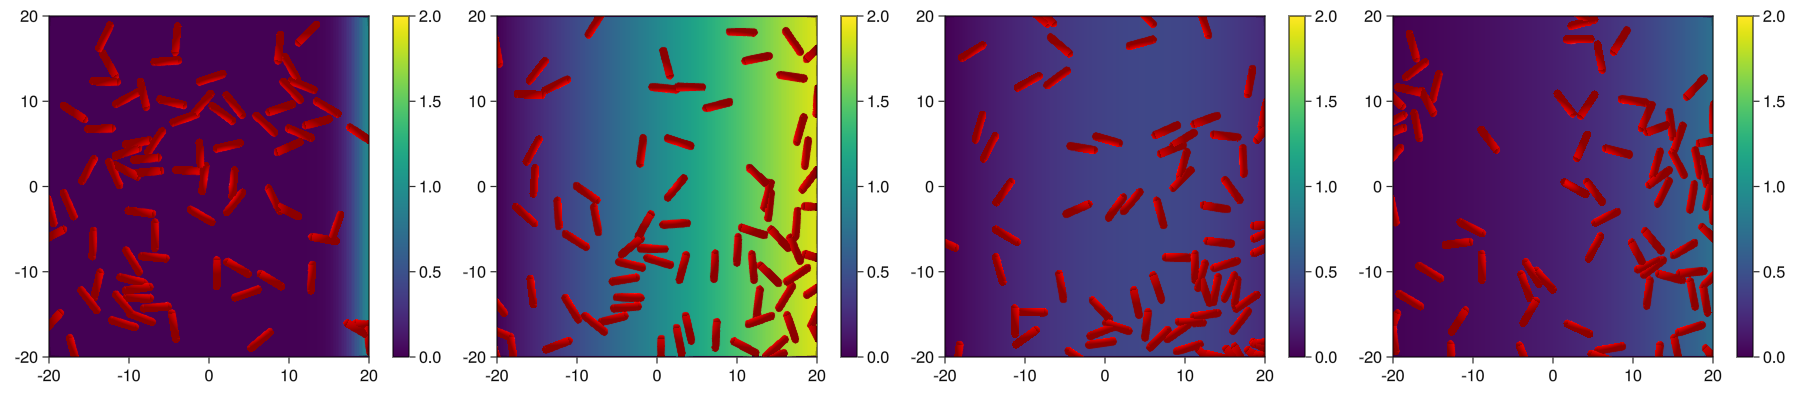

In [9]:
using CellBasedModels
fig = Figure(resolution=(1800,400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com,[:x,:y,:d,:l,:theta,:pressure,:mm])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
            )

        xlims!(com.simBox[1,:]...)
        ylims!(com.simBox[2,:]...)

        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f0(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f0(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)
    end
end

display(fig)
save("C:/Users/s361359/CellBasedModelsF1/results/examples/bacterial_chemotaxis_example.png", fig)


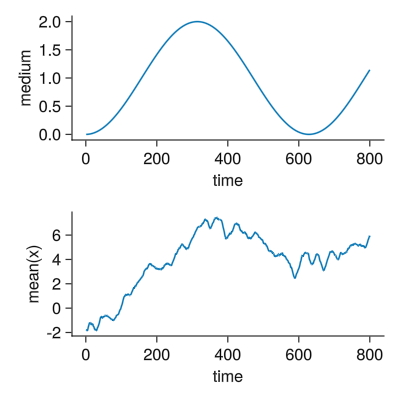

In [11]:
d = getParameter(com,[:x])

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1],xlabel="time",ylabel="medium",
            rightspinevisible=false,
            topspinevisible=false,
            xgridvisible=false,
            ygridvisible=false
        )

lines!(ax,[i.t for i in com.pastTimes],[1-cos(com.ωMedium[1]*i.t) for i in com.pastTimes])

ax2 = Axis(fig[2,1],xlabel="time",ylabel="mean(x)",
            rightspinevisible=false,
            topspinevisible=false,
            xgridvisible=false,
            ygridvisible=false
        )
lines!(ax2,[i.t for i in com.pastTimes],[mean(i) for i in d[:x]])

display(fig)
save("C:/Users/s361359/CellBasedModelsF1/results/examples/bacterial_chemotaxis_statistics.png", fig)